# DC GAN

Deconvolution GAN

In [102]:
import tensorflow as tf
# tf.enable_eager_execution()
import matplotlib.pyplot as plt 
import pandas as pd
%matplotlib inline
print(tf.__version__)

2.0.0-alpha0


In [2]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense
from tensorflow.keras.layers import BatchNormalization, Reshape, UpSampling2D, MaxPool2D, Flatten
import numpy as np 

import tqdm

#  Define Generator

In [3]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()        
        self.dense1 = Dense(1024, activation='tanh', input_dim=(100))
        self.dense2 = Dense(128*7*7, activation='tanh')
        self.bn1 = BatchNormalization()
        self.reshape1 = Reshape((7,7,128),input_shape=(128*7*7,))
        self.up1 = UpSampling2D(size=(2,2))
        self.conv1 = Conv2D(64,(5,5), padding='same', activation='tanh')
        self.up2 = UpSampling2D(size=(2,2))
        self.conv2 = Conv2D(1,(5,5), padding='same', activation='tanh')
        
    def __call__(self, x):
        x = self.dense1(x)        
        x = self.dense2(x)                
        x = self.bn1(x)        
        x = self.reshape1(x)        
        x = self.up1(x)        
        x = self.conv1(x)        
        x = self.up2(x)        
        x = self.conv2(x)        
        return x 

generator 생성, 동작 테스트 

In [4]:
test = tf.random.normal((1,100), dtype=tf.dtypes.float32)
print(test.shape)
g = Generator()
result = g(test[0:])
print(result.shape)

(1, 100)
(1, 28, 28, 1)


# Define Discrimator

In [59]:
class Discrimator(Model):
    def __init__(self):
        super(Discrimator,self).__init__()
        self.conv1 = Conv2D(64, (5,5), padding='same', activation='tanh')
        self.maxPool1 = MaxPool2D(pool_size=(2,2))
        self.conv2 = Conv2D(128, (5,5), padding='same', activation='tanh')
        self.maxPool2 = MaxPool2D(pool_size=(2,2))
        self.flatten = Flatten()
        self.dense1 = Dense(1024, activation='tanh')
        self.dense2 = Dense(1, activation='sigmoid')
        
    def __call__(self, x):
        x = self.conv1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.maxPool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x 

discrimator 생성, 동작 테스트 

In [60]:
test = tf.random.normal((1,28,28,1), dtype=tf.dtypes.float32)
print(test.shape)
d = Discrimator()
result = d(test)
print(result.shape)
print(result)

(1, 28, 28, 1)
(1, 1)
tf.Tensor([[0.40194932]], shape=(1, 1), dtype=float32)


# Define Z (1024)

In [61]:
BATCH_SIZE=32
LATENT_SIZE=100
z = tf.random.uniform(minval=-1,maxval=1,shape=(BATCH_SIZE, LATENT_SIZE), seed=0, dtype=tf.dtypes.float32)

In [62]:
print(z.shape)

(32, 100)


In [63]:
buffer_size =10000 
batch_size =1000

In [64]:
(train_imgs, train_labels), (_,_)  = tf.keras.datasets.mnist.load_data()
train_imgs = train_imgs[train_labels == 0]
print(f"train_imgs : {train_imgs.shape}")
x_train = train_imgs.astype('float32') / 255.0 
x_train = x_train.reshape((x_train.shape[0],) + (28, 28, 1)) 
print(x_train.shape) 

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

train_imgs : (5923, 28, 28)
(5923, 28, 28, 1)


In [133]:
test_array = np.array([0.7,0.0,0.3])
print(tf.keras.losses.categorical_crossentropy(
            y_true=tf.ones_like(test_array), y_pred=test_array, from_logits=True))

print(tf.keras.losses.categorical_crossentropy(
            y_true=tf.ones_like(test_array), y_pred=test_array))

print(tf.keras.losses.categorical_crossentropy(
            y_true=tf.zeros_like(test_array), y_pred=test_array))

print(tf.keras.losses.categorical_crossentropy(
            y_true=tf.zeros_like(test_array), y_pred=test_array, from_logits=True))

print(tf.keras.losses.binary_crossentropy(
            y_true=tf.ones_like(test_array), y_pred=test_array, from_logits=True))
print(tf.keras.losses.binary_crossentropy(
            y_true=tf.zeros_like(test_array), y_pred=test_array, from_logits=True))

print(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(test_array), logits=test_array))

tf.Tensor(3.4199001308743755, shape=(), dtype=float64)
tf.Tensor(17.678743399222988, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.0, shape=(), dtype=float64)
tf.Tensor(0.5502294913046434, shape=(), dtype=float64)
tf.Tensor(0.8835628246379766, shape=(), dtype=float64)
tf.Tensor([0.40318605 0.69314718 0.55435524], shape=(3,), dtype=float64)


loss functions

In [65]:
def convert_array_to_image(array):
    """Converts a numpy array to a PIL Image and undoes any rescaling."""
    img = PIL.Image.fromarray(np.uint8((array + 1.0) / 2.0 * 255), mode='RGB')
    return img


In [66]:
# ?tf.keras.losses.categorical_crossentropy

In [141]:
class GAN_Learner:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.gen_opt = tf.keras.optimizers.Adam(1e-4)
        self.dis_opt = tf.keras.optimizers.Adam(1e-4)
        self.gen_loss = tf.keras.metrics.Mean(name="gen_loss")
        self.dis_loss = tf.keras.metrics.Mean(name="dis_loss")
        self.g_list = []
        self.d_list = []
        
    def generator_loss(self, generated_output):
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(generated_output), logits=generated_output)
       
    def discriminator_loss(self, real_output, generated_output):
        real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output), logits=real_output)
        generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(generated_output), logits=generated_output)
        total_loss = real_loss + generated_loss
        return total_loss
    
    def get_dataset(self):
        (train_imgs, train_labels), (_,_)  = tf.keras.datasets.mnist.load_data()
        train_imgs = train_imgs[train_labels == 0]
        print(f"train_imgs : {train_imgs.shape}")
        x_train = train_imgs.astype('float32') / 255.0 
        x_train = x_train.reshape((x_train.shape[0],) + (28, 28, 1)) 
        new_len = x_train.shape[0] // batch_size
        x_train = x_train[:new_len*batch_size]
        train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(self.batch_size)
        return train_dataset
        
    def train_test(self, epochs):
        try :
            if tf.reset_default_graph :
                tf.reset_default_graph()
        except :
            pass        

        all = 60000
        loaded_count = 0
        self.g = Generator()
        self.d = Discrimator()
        train_dataset = self.get_dataset()

        for epoch in range(0, epochs): 
#             if (epoch+1 % 10) == 0 :
#                 print("Epoch:", epoch + 1) 

            noise = tf.random.uniform(minval=-1,maxval=1,shape=(self.batch_size, LATENT_SIZE), seed=0, dtype=tf.dtypes.float32)

            for imgs in train_dataset:
                if len(imgs) != self.batch_size :
                    print(f"load custom length:{len(imgs)}")
                    noise = tf.random.uniform(minval=-1,maxval=1,shape=(len(imgs), LATENT_SIZE), seed=0, dtype=tf.dtypes.float32)
                loaded_count = loaded_count + len(imgs)
                self.train_step(imgs, noise)
                self.g_list.append(self.gen_loss.result().numpy())
                self.d_list.append(self.dis_loss.result().numpy())
                
            print(f"epoch:{epoch} gen_loss:{self.gen_loss.result()},dis_loss:{self.dis_loss.result()}")            
#         print(f"load img count : {loaded_count}")

        noise = np.random.uniform(-1.0, 1.0, size=[self.batch_size, 100])     
        fake_img = self.g(noise)
        fake_img = np.array(fake_img[0])
        fake_img = fake_img.reshape(fake_img.shape[0], fake_img.shape[1])
        plt.imshow(fake_img)
        plt.show()
        df = pd.DataFrame({"g":self.g_list,"d":self.d_list})
#         print(df)
        df.plot()
        
        
    @tf.function
    def train_step(self, imgs, noise):
        total_d_loss = 0.0 
        total_a_loss = 0.0 

        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:

            gen_imgs = self.g(noise)
            # genearator를 통해서 fake 이미지 생성 

            real_output = self.d(imgs)
            # discrimator를 통해서 이미지에 대한 진짜, 가짜 여부 판별 

            gen_output = self.d(gen_imgs)
            # 생성된 이미지에 대한 진짜, 가짜 여부 판별 

            gen_loss = self.generator_loss(gen_output)
            # generator loss 

            dis_loss= self.discriminator_loss(real_output, gen_output)
            # discriminator loss 
            
            self.gen_loss(gen_loss)
            self.dis_loss(dis_loss)            

        grd_gen = gen_tape.gradient(gen_loss, self.g.trainable_variables)
        grd_dis = dis_tape.gradient(dis_loss, self.d.trainable_variables)
        # gradient 생성 

        self.gen_opt.apply_gradients(zip(grd_gen, self.g.trainable_variables))
        self.dis_opt.apply_gradients(zip(grd_dis, self.d.trainable_variables))
        # bp 수행 
#         print(f"gen_loss:{gen_loss}, dis_loss:{dis_loss}")

train_imgs : (5923, 28, 28)
epoch:0 gen_loss:0.47263583540916443,dis_loss:1.387082576751709


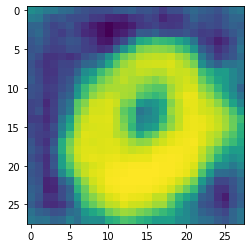

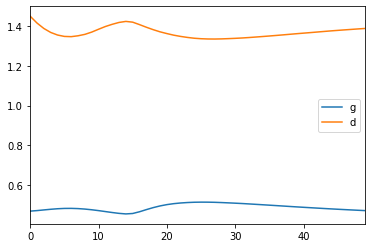

In [142]:
learner = GAN_Learner(100)
learner.train_test(1)

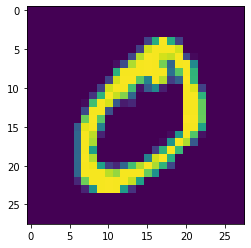

In [143]:
plt.imshow(train_imgs[0])
plt.show()

train_imgs : (5923, 28, 28)
epoch:0 gen_loss:0.48407164216041565,dis_loss:1.3430819511413574
epoch:1 gen_loss:0.5120745301246643,dis_loss:1.3019496202468872
epoch:2 gen_loss:0.5138278603553772,dis_loss:1.3083720207214355
epoch:3 gen_loss:0.508235514163971,dis_loss:1.315145492553711
epoch:4 gen_loss:0.5015600919723511,dis_loss:1.3242107629776
epoch:5 gen_loss:0.4965462386608124,dis_loss:1.3311302661895752
epoch:6 gen_loss:0.5081950426101685,dis_loss:1.3113335371017456
epoch:7 gen_loss:0.5175204873085022,dis_loss:1.300062656402588
epoch:8 gen_loss:0.5242787599563599,dis_loss:1.2874319553375244
epoch:9 gen_loss:0.5287873148918152,dis_loss:1.27882981300354
epoch:10 gen_loss:0.5306997299194336,dis_loss:1.274527668952942
epoch:11 gen_loss:0.5390092730522156,dis_loss:1.2605230808258057
epoch:12 gen_loss:0.5498508214950562,dis_loss:1.2480907440185547
epoch:13 gen_loss:0.5566104650497437,dis_loss:1.2380034923553467
epoch:14 gen_loss:0.5593300461769104,dis_loss:1.2329778671264648
epoch:15 gen_lo

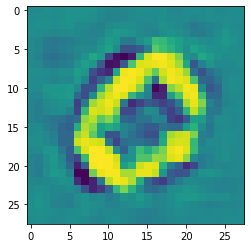

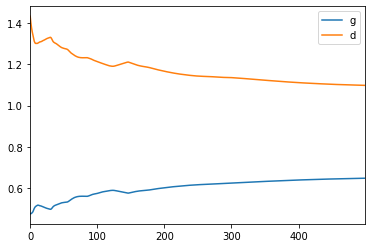

In [148]:
 GAN_Learner(1000).train_test(100)

train_imgs : (5923, 28, 28)
epoch:0 gen_loss:0.48647812008857727,dis_loss:1.3383883237838745
epoch:1 gen_loss:0.49271026253700256,dis_loss:1.3453096151351929
epoch:2 gen_loss:0.4797667860984802,dis_loss:1.3618742227554321
epoch:3 gen_loss:0.4825778305530548,dis_loss:1.3533198833465576
epoch:4 gen_loss:0.49828043580055237,dis_loss:1.3298453092575073
epoch:5 gen_loss:0.5073345303535461,dis_loss:1.3124438524246216
epoch:6 gen_loss:0.5251124501228333,dis_loss:1.283160924911499
epoch:7 gen_loss:0.5406240224838257,dis_loss:1.2610379457473755
epoch:8 gen_loss:0.5415129065513611,dis_loss:1.2588591575622559
epoch:9 gen_loss:0.5508663058280945,dis_loss:1.2492761611938477
epoch:10 gen_loss:0.5603199005126953,dis_loss:1.2357925176620483
epoch:11 gen_loss:0.5680157542228699,dis_loss:1.2229695320129395
epoch:12 gen_loss:0.5762739777565002,dis_loss:1.2089312076568604
epoch:13 gen_loss:0.5780307650566101,dis_loss:1.205575704574585
epoch:14 gen_loss:0.5735544562339783,dis_loss:1.2124199867248535
epoch:

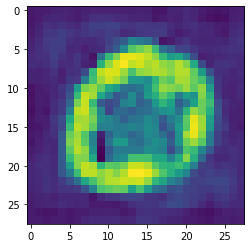

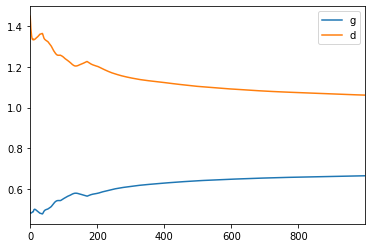

In [150]:
 GAN_Learner(500).train_test(100)

train_imgs : (5923, 28, 28)
epoch:0 gen_loss:0.4699274003505707,dis_loss:1.4435230493545532
epoch:1 gen_loss:0.5145872831344604,dis_loss:1.3450536727905273
epoch:2 gen_loss:0.5059530735015869,dis_loss:1.343394160270691
epoch:3 gen_loss:0.4950457513332367,dis_loss:1.3534783124923706
epoch:4 gen_loss:0.5021901726722717,dis_loss:1.3391529321670532
epoch:5 gen_loss:0.5218912959098816,dis_loss:1.3045926094055176
epoch:6 gen_loss:0.5425583720207214,dis_loss:1.2684990167617798
epoch:7 gen_loss:0.5613816380500793,dis_loss:1.2358818054199219
epoch:8 gen_loss:0.5756638050079346,dis_loss:1.2111573219299316
epoch:9 gen_loss:0.5874118804931641,dis_loss:1.1906977891921997
epoch:10 gen_loss:0.5967457890510559,dis_loss:1.174411416053772
epoch:11 gen_loss:0.6047806739807129,dis_loss:1.1604198217391968
epoch:12 gen_loss:0.6113768219947815,dis_loss:1.1489700078964233
epoch:13 gen_loss:0.6172187328338623,dis_loss:1.1387962102890015
epoch:14 gen_loss:0.6222817897796631,dis_loss:1.1299715042114258
epoch:15 

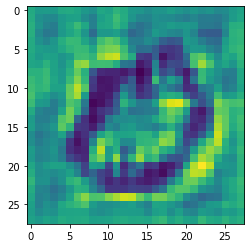

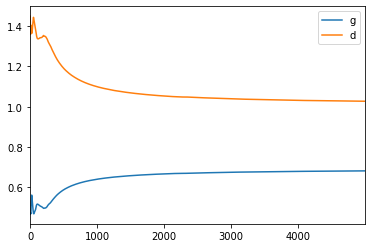

In [146]:
 GAN_Learner(100).train_test(100)

train_imgs : (5923, 28, 28)
epoch:0 gen_loss:0.4151301383972168,dis_loss:1.5145729780197144
epoch:1 gen_loss:0.4131266176700592,dis_loss:1.4906898736953735
epoch:2 gen_loss:0.41952869296073914,dis_loss:1.4712045192718506
epoch:3 gen_loss:0.41670382022857666,dis_loss:1.4712762832641602
epoch:4 gen_loss:0.41121479868888855,dis_loss:1.4775278568267822
epoch:5 gen_loss:0.404712975025177,dis_loss:1.486338496208191
epoch:6 gen_loss:0.4305347204208374,dis_loss:1.4430615901947021
epoch:7 gen_loss:0.46327778697013855,dis_loss:1.3886830806732178
epoch:8 gen_loss:0.4888207018375397,dis_loss:1.3462122678756714
epoch:9 gen_loss:0.5092464685440063,dis_loss:1.312248945236206
epoch:10 gen_loss:0.525966227054596,dis_loss:1.284432053565979
epoch:11 gen_loss:0.5398994088172913,dis_loss:1.2612508535385132
epoch:12 gen_loss:0.5515515804290771,dis_loss:1.2418770790100098
epoch:13 gen_loss:0.56166672706604,dis_loss:1.2250465154647827
epoch:14 gen_loss:0.5704331994056702,dis_loss:1.2104600667953491
epoch:15 g

epoch:127 gen_loss:0.6789040565490723,dis_loss:1.0302132368087769
epoch:128 gen_loss:0.6790191531181335,dis_loss:1.0300273895263672
epoch:129 gen_loss:0.6791324615478516,dis_loss:1.0298445224761963
epoch:130 gen_loss:0.6792440414428711,dis_loss:1.029664397239685
epoch:131 gen_loss:0.6793539524078369,dis_loss:1.0294870138168335
epoch:132 gen_loss:0.679462194442749,dis_loss:1.029312252998352
epoch:133 gen_loss:0.6795687675476074,dis_loss:1.0291402339935303
epoch:134 gen_loss:0.6796738505363464,dis_loss:1.0289705991744995
epoch:135 gen_loss:0.6797773241996765,dis_loss:1.0288035869598389
epoch:136 gen_loss:0.6798793077468872,dis_loss:1.0286389589309692
epoch:137 gen_loss:0.6799798607826233,dis_loss:1.0284767150878906
epoch:138 gen_loss:0.68007892370224,dis_loss:1.028316855430603
epoch:139 gen_loss:0.6801765561103821,dis_loss:1.0281591415405273
epoch:140 gen_loss:0.6802728176116943,dis_loss:1.0280038118362427
epoch:141 gen_loss:0.6803677082061768,dis_loss:1.02785062789917
epoch:142 gen_loss

epoch:252 gen_loss:0.6862390041351318,dis_loss:1.018373727798462
epoch:253 gen_loss:0.6862685680389404,dis_loss:1.018325924873352
epoch:254 gen_loss:0.6862978935241699,dis_loss:1.0182785987854004
epoch:255 gen_loss:0.6863269805908203,dis_loss:1.0182316303253174
epoch:256 gen_loss:0.6863558888435364,dis_loss:1.018185019493103
epoch:257 gen_loss:0.6863845586776733,dis_loss:1.0181387662887573
epoch:258 gen_loss:0.6864129900932312,dis_loss:1.0180928707122803
epoch:259 gen_loss:0.68644118309021,dis_loss:1.0180473327636719
epoch:260 gen_loss:0.6864691972732544,dis_loss:1.0180021524429321
epoch:261 gen_loss:0.6864969730377197,dis_loss:1.0179572105407715
epoch:262 gen_loss:0.6865245699882507,dis_loss:1.017912745475769
epoch:263 gen_loss:0.6865519285202026,dis_loss:1.0178685188293457
epoch:264 gen_loss:0.6865791082382202,dis_loss:1.0178247690200806
epoch:265 gen_loss:0.6866060495376587,dis_loss:1.0177812576293945
epoch:266 gen_loss:0.6866328120231628,dis_loss:1.0177379846572876
epoch:267 gen_lo

epoch:377 gen_loss:0.6887227296829224,dis_loss:1.0143646001815796
epoch:378 gen_loss:0.6887360215187073,dis_loss:1.0143431425094604
epoch:379 gen_loss:0.6887491941452026,dis_loss:1.0143218040466309
epoch:380 gen_loss:0.6887623071670532,dis_loss:1.0143007040023804
epoch:381 gen_loss:0.6887754201889038,dis_loss:1.0142796039581299
epoch:382 gen_loss:0.6887883543968201,dis_loss:1.014258623123169
epoch:383 gen_loss:0.6888012886047363,dis_loss:1.0142377614974976
epoch:384 gen_loss:0.6888141632080078,dis_loss:1.0142170190811157
epoch:385 gen_loss:0.6888269186019897,dis_loss:1.0141963958740234
epoch:386 gen_loss:0.6888396739959717,dis_loss:1.0141758918762207
epoch:387 gen_loss:0.6888523101806641,dis_loss:1.014155387878418
epoch:388 gen_loss:0.6888648867607117,dis_loss:1.0141351222991943
epoch:389 gen_loss:0.6888774633407593,dis_loss:1.0141148567199707
epoch:390 gen_loss:0.6888899207115173,dis_loss:1.0140947103500366
epoch:391 gen_loss:0.6889023184776306,dis_loss:1.0140748023986816
epoch:392 ge

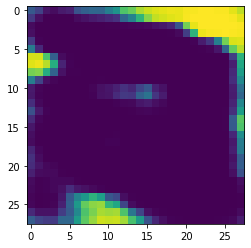

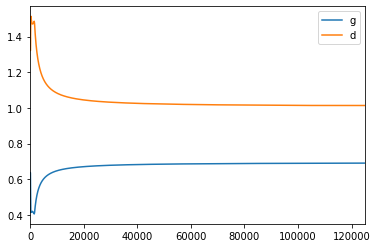

In [129]:
 GAN_Learner(20).train_test(500)

train_imgs : (5923, 28, 28)
epoch:0 gen_loss:0.3757006824016571,dis_loss:1.543468952178955


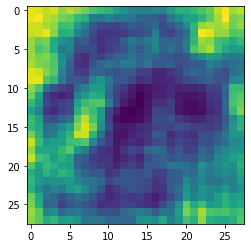

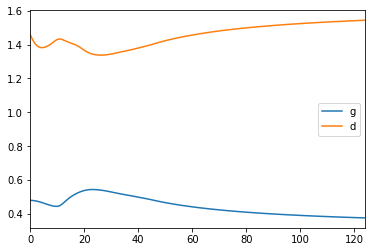

In [130]:
 GAN_Learner(40).train_test(1)

train_imgs : (5923, 28, 28)
epoch:0 gen_loss:0.5476975440979004,dis_loss:1.2997674942016602
epoch:1 gen_loss:0.4775819778442383,dis_loss:1.386391282081604
epoch:2 gen_loss:0.46773308515548706,dis_loss:1.3931186199188232
epoch:3 gen_loss:0.4549153447151184,dis_loss:1.4093878269195557
epoch:4 gen_loss:0.4513792097568512,dis_loss:1.4123440980911255
epoch:5 gen_loss:0.4521014988422394,dis_loss:1.4092825651168823
epoch:6 gen_loss:0.45139044523239136,dis_loss:1.4090982675552368
epoch:7 gen_loss:0.44871580600738525,dis_loss:1.4124643802642822
epoch:8 gen_loss:0.44421982765197754,dis_loss:1.419022798538208
epoch:9 gen_loss:0.43702754378318787,dis_loss:1.430144190788269


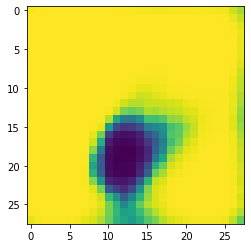

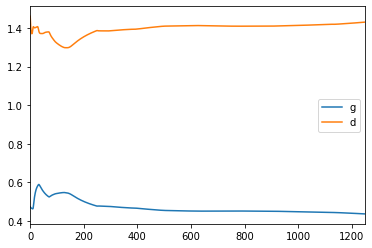

In [131]:
 GAN_Learner(40).train_test(10)